In [1]:
## Doc

In [2]:
## Import and define libraries

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from model.layers.ContentExtractor import ContentExtractor
from model.layers.PreprocessInput import PreprocessInput
from model.layers.StyleExtractor import StyleExtractor
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [3]:
## Import utils

from ImgUtil import load_img, imshow, tensor_to_image
from model.StyleContentExtractor import StyleContentExtractor, style_layers_const, content_layers_const

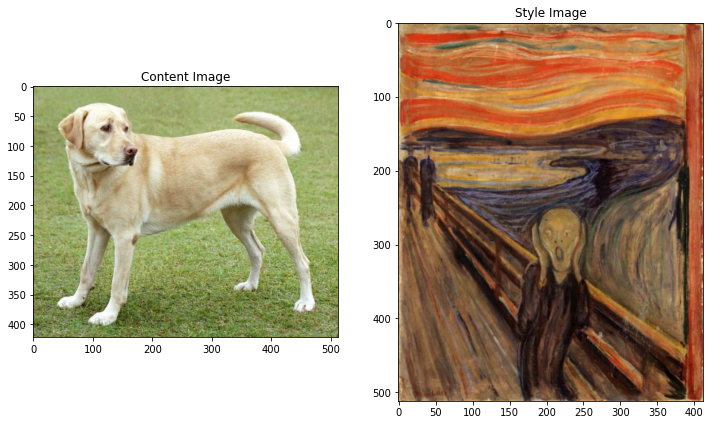

In [4]:
## Import and show images

content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('test2.jpg', 'https://uploads2.wikiart.org/images/edvard-munch/the-scream-1893(2).jpg!Large.jpg')

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [5]:
## Fast neural transfer

# import tensorflow_hub as hub
# hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
# stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
# tensor_to_image(stylized_image)

In [6]:
## Create Style&Content Extraction models

extractor = StyleContentExtractor((None, None, None, 3))

# preprocess_input = PreprocessInput()
# style_extract = StyleExtractor()
# content_extract = ContentExtractor()

In [7]:
# style_targets = style_extract(preprocess_input.call(style_image))
# content_targets = content_extract(preprocess_input.call(content_image))

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

print('Styles:')
for name, output in sorted(style_targets.items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(content_targets.items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.011761198
    max:  13989.091
    mean:  426.18262

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  83345.836
    mean:  11949.014

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  352476.53
    mean:  13483.084

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4725004.0
    mean:  192786.3

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  50534.67
    mean:  1079.9086

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


In [8]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [9]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

# def style_content_loss(style_outputs, content_outputs):
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / 5

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / 5
    loss = style_loss + content_loss
    return loss

In [10]:
total_variation_weight=30

def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)

        # style_outputs = style_extract(preprocess_input(image))
        # content_outputs = content_extract(preprocess_input(image))

        # loss = style_content_loss(style_outputs, content_outputs)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))


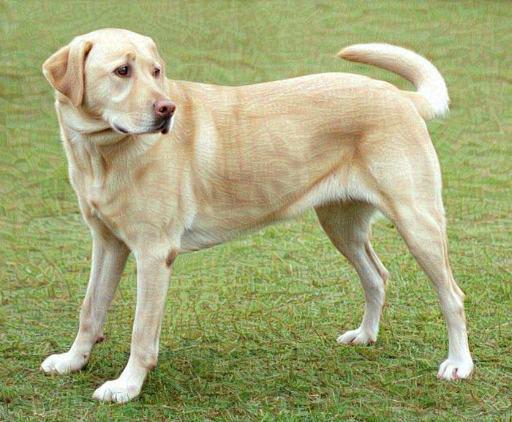

In [11]:
image = tf.Variable(content_image)

train_step(image)
tensor_to_image(image)

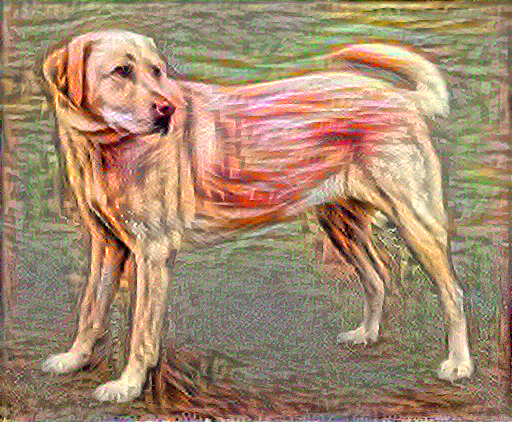

Train step: 100
Total time: 11.5


In [12]:
import time
import IPython.display as display

start = time.time()

epochs = 2
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

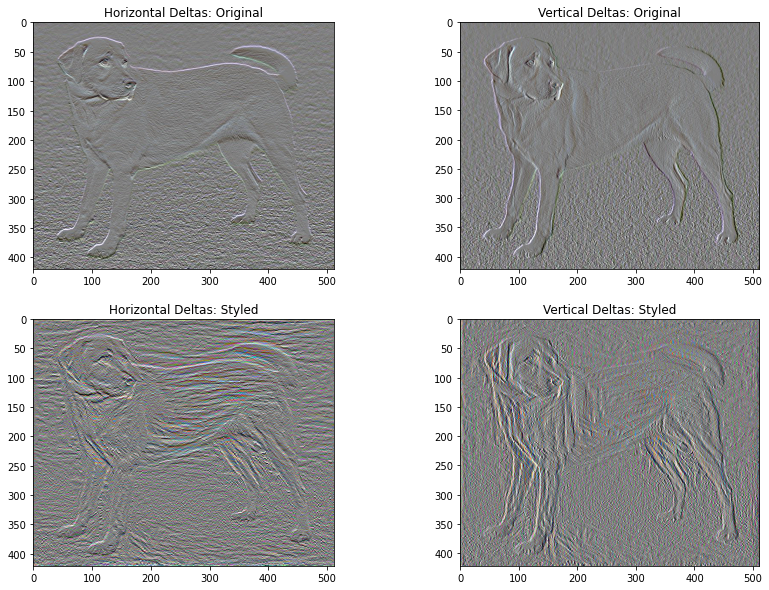

In [13]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

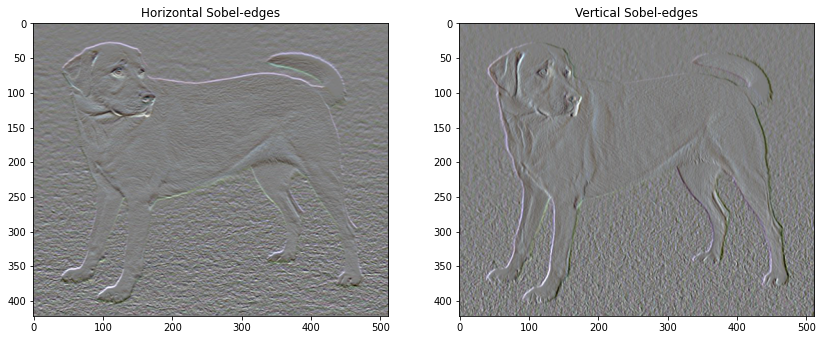

In [14]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")
